# Demo: DNN-Regressor based on Entity Embedding for categorical variables

In [1]:
import numpy as np
import pandas as pd
from demo_pre_processor import MyPreprocessor
from df2numpy import TransformDF2Numpy
from model import CategoricalDnn
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

### Load dataset
* Challenge: predicting guesthouse prices from various columns

In [2]:
csv_dir = "./demodata.csv"
df = pd.read_csv(csv_dir)

print("number of  columns: ", len(df.columns))
print("number of rows: ", len(df))
pd.set_option('display.max_columns', 100)
df.head()

number of  columns:  40
number of rows:  73181


,listing_id,host_since,host_id,picture_url,host_thumbnail_url,calendar_updated,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,smart_location,country_code,has_availability,requires_license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price
0,73345,2016-09-05,09cd543d7ff94bd0,918781121f397557,076bd9e54df95623,17 months ago,NaN,NaN,NaN,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,t,House,Entire home/apt,4,1.0,2.0,2.0,Real Bed,NaN,549c,9b20,t,f,7827,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.08,19301.40
1,27814,2014-03-03,f60538450bd9297e,7cbf0883e639d363,f96b57e18d1073f3,3 days ago,within an hour,100%,NaN,f,4.0,4.0,"['email', 'phone', 'reviews']",t,f,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,7369,9b20,t,f,9b2d,t,f,strict_14_with_grace_period,f,f,4,0,2,2,3.27,16084.50
2,16918,2012-01-10,f8a1ee9b81fe5723,4686f38136a7fa81,0e2756604a8385db,7 months ago,NaN,NaN,NaN,f,0.0,0.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,t,Apartment,Entire home/apt,6,2.0,2.0,3.0,Real Bed,NaN,17a8,9b20,t,f,9b2d,f,f,moderate,f,f,1,1,0,0,0.27,26807.50
3,32243,2018-09-17,af9d35ea0aa40839,d25e8725ee5d3aa2,819d3fff6e00aaeb,7 weeks ago,within an hour,100%,NaN,t,1.0,1.0,"['phone', 'offline_government_id', 'selfie', '...",t,f,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,b523,9b20,t,f,9b2d,t,f,moderate,f,f,1,0,1,0,4.24,7506.10
4,4877,2013-03-08,5cc090234ddb5cd1,8d869dab9c6469e9,f6aaf37a8fd77b03,5 months ago,NaN,NaN,NaN,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,17a8,9b20,t,f,9b2d,f,f,moderate,f,f,1,0,1,0,0.09,12331.45


### Split dataset into train and validation dataset / Minimal pre-processing for some columns

In [3]:
processor = MyPreprocessor()

# avoiding data leakage
df_train, df_val = train_test_split(df, test_size=0.1, random_state=10)
processed_df_train = processor.fit_transform(df_train)
processed_df_val = processor.transform(df_val)

# # allowing data leakage
# processed_df = processor.fit_transform(df)

print("number of  columns: ", len(processed_df_train.columns))
print("number of rows: ", len(processed_df_train))
processed_df_train.head()

number of  columns:  47
number of rows:  65862


,host_id,host_thumbnail_url,host_is_superhost,host_listings_count,host_identity_verified,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,smart_location,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price,calendar_updated_days,host_response_hours,host_response_rate_new,host_response_category,day_diff,host_verification_identity_manual,host_verification_google,host_verification_government_id,host_verification_kba,host_verification_jumio,host_verification_email,host_verification_reviews,host_verification_offline_government_id,host_verification_manual_offline,host_verification_facebook,host_verification_phone,host_verification_selfie,host_verification_work_email,host_verification_sesame,square_feet_or_not
65893,6441cd44226ffccd,9557ad31b170e103,f,43.0,t,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,0.0,f982,f,43ad,t,strict_14_with_grace_period,f,t,41,41,0,0,0.65,15977.27,0.0,1.0,98.0,t,0.0,f,f,t,t,f,t,t,t,f,f,t,t,t,f,f
11895,46dbe83b45c0fa9b,7124dbd223be4e51,f,4.0,f,f,House,Shared room,1,1.0,1.0,1.0,Real Bed,0.0,549c,f,7827,t,strict_14_with_grace_period,f,f,4,0,0,4,0.84,3109.67,21.0,1.0,100.0,t,-2929.0,f,f,f,f,f,t,t,f,f,f,t,f,f,f,f
55521,61bc83c4330692b9,26182126f20b35ce,t,1.0,t,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,0.0,17a8,f,9b2d,f,flexible,f,f,1,1,0,0,0.52,16084.50,28.0,3.0,100.0,t,-2193.0,f,f,f,t,f,t,t,f,f,f,t,f,f,f,f
19817,4e57055ab5c2c4cd,55b10c80bb094f74,f,2.0,f,f,Apartment,Entire home/apt,3,1.0,0.0,1.0,Real Bed,0.0,28b8,t,e3cc,t,moderate,f,f,2,2,0,0,6.06,9650.70,14.0,1.0,100.0,t,-2789.0,t,f,t,f,f,t,t,t,f,f,t,t,f,f,f
16412,9a1ec97eb0a555ac,4648f6567b8fd20a,f,51.0,t,f,Apartment,Entire home/apt,6,2.0,2.0,2.0,Real Bed,0.0,40e5,f,7827,t,strict_14_with_grace_period,f,f,36,36,0,0,1.37,32169.00,1.0,1.0,100.0,t,-1243.0,f,f,f,t,f,t,t,f,t,f,t,f,f,f,f


### Fit a transformation from DataFrame to Numpy array
* df2numpy.TransformDF2Numpy is a tool for quick transformation from pandas.DataFrame to numpy.array dataset.
* See https://github.com/kitayama1234/TransformDF2Numpy for more detail

In [4]:
trans = TransformDF2Numpy(objective_col='price',
                                                    objective_scaling=True,
                                                    numerical_scaling=True,
                                                    scaling_robustness_factor=0.0001,
                                                    fillnan=True,
                                                    fillnan_robustness_factor=0.1,
                                                    min_category_count=3)

# avoiding data leakage
X_train, y_train = trans.fit_transform(processed_df_train)
X_val, y_val = trans.transform(processed_df_val)

# # allowing data leakage
# X, y = trans.fit_transform(processed_df)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=10)

np.set_printoptions(threshold=10000)
print()
print("A sample from pre-processed train data: ")
print()
print(X_train[0, :])

Starting to fit a transformer of TransformDF2Numpy.
Categories thresholded: (column: 'host_id'), (valid categories: 2953, dropped categories: 44882)
Categories thresholded: (column: 'host_thumbnail_url'), (valid categories: 2949, dropped categories: 44782)
Numerical NaNs filled with alternative value: (column: 'host_is_superhost'), (filled rows: 35, value: 0.320128)
Numerical NaNs filled with alternative value: (column: 'host_listings_count'), (filled rows: 35, value: 3.801097)
Numerical NaNs filled with alternative value: (column: 'host_identity_verified'), (filled rows: 35, value: 0.486505)
Categories thresholded: (column: 'property_type'), (valid categories: 35, dropped categories: 12)
Numerical NaNs filled with alternative value: (column: 'bathrooms'), (filled rows: 49, value: 1.186526)
Numerical NaNs filled with alternative value: (column: 'bedrooms'), (filled rows: 24, value: 1.239250)
Numerical NaNs filled with alternative value: (column: 'beds'), (filled rows: 25, value: 1.6321

### Define DataLoaders for applying to a DNN model

In [5]:
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
y_train = torch.from_numpy(y_train.reshape(-1, 1)).float()
y_val = torch.from_numpy(y_val.reshape(-1, 1)).float()

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

### Define DNN model
* "make_embedding_construction" :
    - compression_factor   :   the embedded dimension was calculated as
    $$
     (dimension \ of \ embedded feature) = (number \ of \ dictionaries) * compression\_factor
     $$
    - max_embedded_features   :   max dimension of embedded feature of each categorical variable

In [6]:
def make_embedding_construction(trans, compression_factor, max_embedded_features):
    embedding_construction = []
    total_embedded_features = 0
    for uniques in trans.nuniques():
        target = int(uniques * compression_factor)
        if target < 2:
            target = 2
        elif target > max_embedded_features:
            target = max_embedded_features
        embedding_construction.append([uniques, target])
        total_embedded_features += target
    total_features = total_embedded_features + trans.num_numericals
    return embedding_construction


emb_const = make_embedding_construction(trans, 1/4, 120)

model = CategoricalDnn(categorical_dicts_to_dims=emb_const,
                                          num_numerical_features=trans.num_numericals,
                                          fc_layers_construction=[100, 70],
                                          dropout_probability=0.1)

print(model)

CategoricalDnn(
  (embedding_layer_list): ModuleList(
    (0): Sequential(
      (0): Embedding(2954, 120)
      (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Embedding(2950, 120)
      (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Embedding(36, 9)
      (1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Embedding(3, 2)
      (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Embedding(5, 2)
      (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Sequential(
      (0): Embedding(256, 64)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (6): Sequential(
      (0): Embedding(23, 5)
      (1): Bat

### Define optimizer

In [7]:
optimizer = torch.optim.SGD(model.parameters(),
                                                   lr=0.005,
                                                   momentum=0.9,
                                                   weight_decay=0.0005)

### Define loss function
* Mean Squared Error with L2 regularization to suppress overlearning

In [8]:
class RegularizedMSELoss:
    def __init__(self, p=2, lam=0.0001):
        self.p = p         # L2 : p = 2,    L1 : p = 1
        self.lam = lam

    def __call__(self, y1, y2):
        reg = 0.
        for param in optimizer.param_groups[0]['params']:
            reg += (param.abs() ** self.p).sum()
        reg = reg ** (1 / self.p) * self.lam / self.p
        return ((y1 - y2) ** 2).mean() + reg

    def evaluate(self, y1, y2):
        return ((y1 - y2) ** 2).mean()


criterion = RegularizedMSELoss()

### Training

In [9]:
# evaluating function for validation dataset
def evaluation(model, loader):
    predicted = None
    true_y = None
    model.eval()
    for i, (batch_test_x, batch_test_y) in enumerate(loader):
        batch_predicted = model(batch_test_x)
        batch_predicted = batch_predicted
        if i == 0:
            true_y = batch_test_y
            predicted = batch_predicted
        else:
            true_y = torch.cat([true_y, batch_test_y], axis=0)
            predicted = torch.cat([predicted, batch_predicted], axis=0)
    return criterion.evaluate(true_y, predicted), predicted, true_y


# learning rate scheduler
def lr_schedule(e):
    if e in [35, 55, 70]:
        print("lr updated")
        optimizer.param_groups[0]["lr"] *= 0.1


# training function
def train(epochs):
    loss_in_one_epoch = torch.zeros(train_loader.__len__())
    for epoch in range(epochs):
        model.train()
        lr_schedule(epoch)
        for batch_index, (batch_x, batch_y) in enumerate(train_loader):
            out = model(batch_x)
            loss_temp = criterion(out, batch_y)
            optimizer.zero_grad()
            loss_temp.backward()
            optimizer.step()
            loss_in_one_epoch[batch_index] = loss_temp
        if epoch % 5 == 0:
            loss = loss_in_one_epoch.mean()
            loss_val = evaluation(model, val_loader)[0]
            print("epoch: ", epoch, ", train loss: ", float(loss), end="")
            print(", val loss: ", float(loss_val))


train(75)

epoch:  0 , train loss:  0.6224937438964844, val loss:  0.4220523536205292
epoch:  5 , train loss:  0.48077332973480225, val loss:  0.3651916980743408
epoch:  10 , train loss:  0.44776132702827454, val loss:  0.3640574812889099
epoch:  15 , train loss:  0.41975224018096924, val loss:  0.34878501296043396
epoch:  20 , train loss:  0.4112856388092041, val loss:  0.3484566807746887
epoch:  25 , train loss:  0.3978687524795532, val loss:  0.3636205792427063
epoch:  30 , train loss:  0.3890937566757202, val loss:  0.34864842891693115
lr updated
epoch:  35 , train loss:  0.35825368762016296, val loss:  0.3394351899623871
epoch:  40 , train loss:  0.35131222009658813, val loss:  0.3395903706550598
epoch:  45 , train loss:  0.3531420826911926, val loss:  0.3378647267818451
epoch:  50 , train loss:  0.3487972319126129, val loss:  0.33892980217933655
lr updated
epoch:  55 , train loss:  0.33740368485450745, val loss:  0.33769622445106506
epoch:  60 , train loss:  0.34291455149650574, val loss:  

### Plot result
* Show final loss of validation data
* Plot validation data predictions and correct answers
* (Loss seems to be greatly affected by outliers of the objective variable)

final val loss:  0.33726382


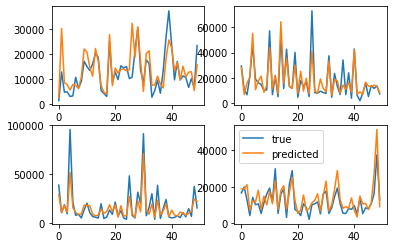

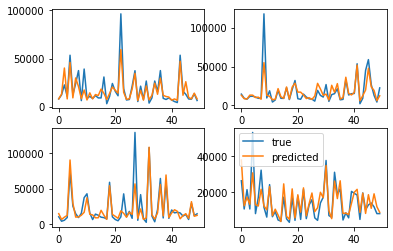

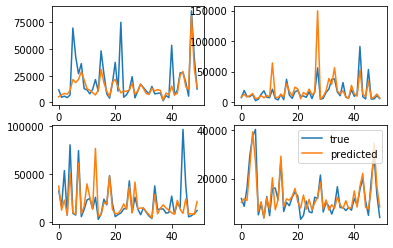

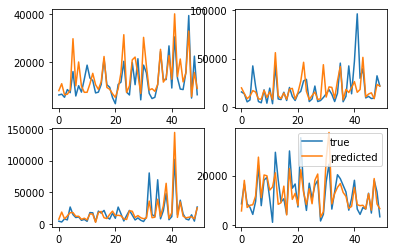

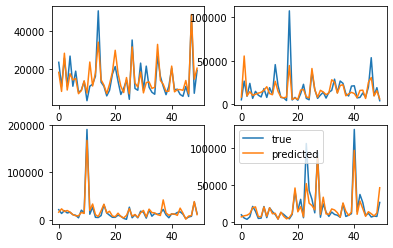

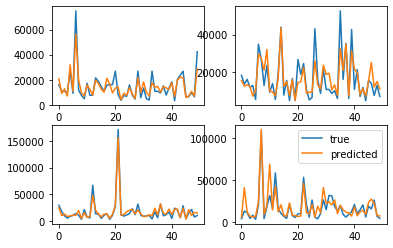

In [10]:
loss_val_final, predicted, true_y = evaluation(model, val_loader)
print("final val loss: ", loss_val_final.detach().numpy())

predicted = torch.clamp(predicted * trans.y_std + trans.y_mean, 0, None)
true_y = true_y * trans.y_std + trans.y_mean
predicted = predicted.squeeze().detach().numpy()
true_y = true_y.squeeze().detach().numpy()


def plot_result(sample_index=0):
    ncols = 2
    nrows = 2
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows)
    for i in range(ncols):
        for j in range(nrows):
            t_y = true_y[sample_index:sample_index + 50]
            pred = predicted[sample_index:sample_index + 50]
            ax[j, i].plot(t_y, label="true")
            ax[j, i].plot(pred, label="predicted")
            sample_index += 50
    plt.legend()
    plt.show()


plot_result()
plot_result(200)
plot_result(400)
plot_result(600)
plot_result(800)
plot_result(1000)